In [1]:
import functools
import numpy as np
import os, random, math
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
def set_memory_growth():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices('GPU')
                print("Detect {} Physical GPUs, {} Logical GPUs.".format(len(gpus), len(logical_gpus)))
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

## TFRecord Creator

In [3]:
class TFRecordCreator:

    def __init__(self, hr_images_path, lr_images_path):
        self.hr_images_path = hr_images_path
        self.lr_images_path = lr_images_path
    
    def _byte_feature(self, val):
        val = val.numpy() if isinstance(val, type(tf.constant(0))) else val
        return tf.train.Feature(
            bytes_list=tf.train.BytesList(
                value=[val]
            )
        )
    
    def _float_feature(self, val):
        return tf.train.Feature(
            float_list=tf.train.FloatList(
                value=[val]
            )
        )
    
    def _int64_feature(self, val):
        return tf.train.Feature(
            int64_list=tf.train.Int64List(
                value=[val]
            )
        )
    
    def make_binary_example(self, image_name, hr_img_str, lr_img_str):
        feature = {
            'image/img_name': self._byte_feature(image_name),
            'image/hr_image': self._byte_feature(hr_img_str),
            'image/lr_image': self._byte_feature(lr_img_str)
        }
        return tf.train.Example(
            features=tf.train.Features(
                feature=feature
            )
        )
    
    def make_tfrecord_file(self, output_path):
        samples = []
        for hr_img_path in glob(self.hr_images_path + '/*.png'):
            image_name = os.path.basename(hr_img_path).replace('.png', '')
            lr_img_path = os.path.join(self.lr_images_path, image_name + 'x4.png')
            samples.append((
                image_name,
                hr_img_path,
                lr_img_path
            ))
        random.shuffle(samples)
        with tf.io.TFRecordWriter(output_path) as writer:
            for img_name, hr_img_path, lr_img_path in tqdm(samples):
                hr_img_str = open(hr_img_path, 'rb').read()
                lr_img_str = open(lr_img_path, 'rb').read()
                tf_example = self.make_binary_example(
                    str.encode(img_name),
                    hr_img_str, lr_img_str
                )
                writer.write(tf_example.SerializeToString())

In [4]:
tfrecord_creator = TFRecordCreator(
    './DIV2K_train_HR/',
    './DIV2K_train_LR_bicubic/X4'
)
tfrecord_creator.make_tfrecord_file('div2d_4x_bicubic.tfrecord')

100%|██████████| 800/800 [00:04<00:00, 162.32it/s]


## Dataloader

In [5]:
class Augmentation:

    def __init__(self):
        pass
    
    @staticmethod
    def flip_lr(img_1, img_2):
        do_flip = tf.random.uniform([]) > 0.5
        img_1 = tf.cond(do_flip, lambda: tf.image.flip_left_right(img_1), lambda: img_1)
        img_2 = tf.cond(do_flip, lambda: tf.image.flip_left_right(img_2), lambda: img_2)
        return img_1, img_2
    
    @staticmethod
    def flip_ud(img_1, img_2):
        do_flip = tf.random.uniform([]) > 0.5
        img_1 = tf.cond(do_flip, lambda: tf.image.flip_up_down(img_1), lambda: img_1)
        img_2 = tf.cond(do_flip, lambda: tf.image.flip_up_down(img_2), lambda: img_2)
        return img_1, img_2
    
    @staticmethod
    def rotate_90(img_1, img_2):
        do_rotation = tf.random.uniform([])
        angle = tf.random.uniform([]).numpy() * 3
        img_1 = tf.cond(do_rotation, lambda: tf.image.rot90(img_1, k=math.ceil(angle)), lambda: img_1)
        img_2 = tf.cond(do_rotation, lambda: tf.image.rot90(img_2, k=math.ceil(angle)), lambda: img_2)
        return img_1, img_2

In [6]:
class SRTfrecordDataset:

    def __init__(self, gt_size, scale=4, apply_flip=True, apply_rotation=True):
        self.gt_size = gt_size
        self.scale = scale
        self.apply_flip = apply_flip
        self.apply_rotation = apply_rotation
    
    def apply_random_crop(self, lr_image, hr_image):
        lr_image_shape = tf.shape(lr_image)
        hr_image_shape = tf.shape(hr_image)
        gt_shape = (
            self.gt_size,
            self.gt_size,
            3
        )
        lr_shape = (
            self.gt_size // self.scale,
            self.gt_size // self.scale,
            3
        )
        limit = lr_image_shape - lr_shape + 1
        offset = tf.random.uniform(
            tf.shape(lr_image_shape),
            dtype=tf.int32, maxval=tf.int32.max
        ) % limit
        lr_image = tf.slice(lr_image, offset, lr_shape)
        hr_image = tf.slice(hr_image, offset * self.scale, gt_shape)
        return lr_image, hr_image
    
    def normalize(self, lr_image, hr_image):
        return lr_image / 255, hr_image / 255
    
    @staticmethod
    def denormalize(image):
        return (image + 1.0) / 2.0
    
    def parse_tfrecord(self, tfrecord_file):
        def parse(tfrecord):
            features = {
                'image/img_name': tf.io.FixedLenFeature([], tf.string),
                'image/hr_image': tf.io.FixedLenFeature([], tf.string),
                'image/lr_image': tf.io.FixedLenFeature([], tf.string)
            }
            x = tf.io.parse_single_example(tfrecord, features)
            lr_image = tf.image.decode_png(x['image/lr_image'], channels=3)
            hr_image = tf.image.decode_png(x['image/hr_image'], channels=3)
            lr_image, hr_image = self.apply_random_crop(lr_image, hr_image)
            lr_image, hr_image = self.normalize(lr_image, hr_image)
            return lr_image, hr_image
        return parse
    
    def get_dataset(self, tfrecord_file, batch_size, buffer_size):
        dataset = tf.data.TFRecordDataset(tfrecord_file)
        dataset = dataset.repeat()
        dataset = dataset.shuffle(buffer_size=buffer_size)
        dataset = dataset.map(
            self.parse_tfrecord(tfrecord_file),
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
        dataset = dataset.map(
            Augmentation.flip_lr,
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
        dataset = dataset.map(
            Augmentation.flip_ud,
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(
            buffer_size=tf.data.experimental.AUTOTUNE
        )
        return dataset

In [7]:
set_memory_growth()
dataloader = SRTfrecordDataset(256)
dataset = dataloader.get_dataset('./div2d_4x_bicubic.tfrecord', 8, 1024)
dataset

Physical devices cannot be modified after being initialized


<PrefetchDataset shapes: ((8, 64, 64, 3), (8, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [8]:
def visualize_batch(dataset, model=None):
    x_batch, y_batch = next(iter(dataset))
    x_batch = x_batch.numpy()
    y_batch = y_batch.numpy()
    c = 0
    if model is None:
        fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 16))
        plt.setp(axes.flat, xticks = [], yticks = [])
        for i, ax in enumerate(axes.flat):
            if i % 2 == 0:
                ax.imshow(x_batch[c])
                ax.set_xlabel('Low_Res_' + str(c + 1))
            elif i % 2 == 1:
                ax.imshow(SRTfrecordDataset.denormalize(y_batch[c]))
                ax.set_xlabel('High_Res_' + str(c + 1))
                c += 1
    else:
        fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 16))
        plt.setp(axes.flat, xticks = [], yticks = [])
        for i, ax in enumerate(axes.flat):
            if i % 3 == 0:
                ax.imshow(x_batch[c])
                ax.set_xlabel('Low_Res_' + str(c + 1))
            elif i % 3 == 1:
                ax.imshow(SRTfrecordDataset.denormalize(y_batch[c]))
                ax.set_xlabel('High_Res_' + str(c + 1))
            elif i % 3 == 2:
                ax.imshow(np.squeeze(SRTfrecordDataset.denormalize(model(np.expand_dims(x_batch[c], axis=0)))))
                ax.set_xlabel('High_Res_' + str(c + 1))
                c += 1
    plt.show()

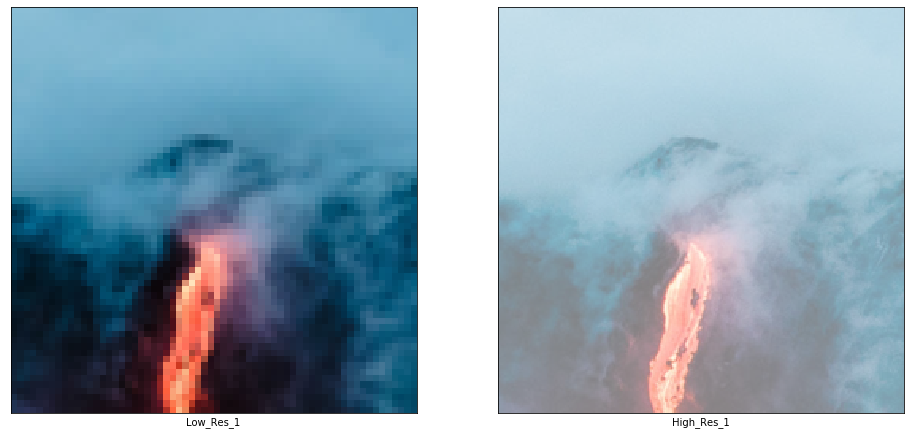

In [9]:
visualize_batch(dataset)

## Models

In [10]:
def kernel_regularizer(weight_decay=5e-4):
    '''L2 Weight Decay
    Params:
        weight_decay -> Weight Decay
    '''
    return tf.keras.regularizers.l2(weight_decay)


def kernel_initializer(scale=1.0, seed=None):
    '''He normal initializer with scale'''
    scale = 2. * scale
    return tf.keras.initializers.VarianceScaling(
        scale=scale, mode='fan_in',
        distribution="truncated_normal", seed=seed
    )


class BatchNormalization(tf.keras.layers.BatchNormalization):
    '''Make trainable=False freeze BN for real (the og version is sad).
    Reference: https://github.com/zzh8829/yolov3-tf2
    '''
    
    def __init__(
        self, axis=-1, momentum=0.9,
        epsilon=1e-5, center=True,
        scale=True, name=None, **kwargs):
        
        super(BatchNormalization, self).__init__(
            axis=axis, momentum=momentum,
            epsilon=epsilon, center=center,
            scale=scale, name=name, **kwargs
        )

    def call(self, x, training=False):
        if training is None:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)


class ResDenseBlock5C(tf.keras.layers.Layer):
    '''Residual Dense Block'''
    
    def __init__(
        self, nf=64, gc=32, res_beta=0.2,
        wd=0., name='RDB5C', **kwargs):
        
        super(ResDenseBlock5C, self).__init__(name=name, **kwargs)
        self.res_beta = res_beta
        lrelu_f = functools.partial(tf.keras.layers.LeakyReLU, alpha=0.2)
        _Conv2DLayer = functools.partial(
            tf.keras.layers.Conv2D, kernel_size=3,
            padding='same', kernel_initializer=kernel_initializer(0.1),
            bias_initializer='zeros', kernel_regularizer=kernel_regularizer(wd)
        )
        self.conv1 = _Conv2DLayer(filters=gc, activation=lrelu_f())
        self.conv2 = _Conv2DLayer(filters=gc, activation=lrelu_f())
        self.conv3 = _Conv2DLayer(filters=gc, activation=lrelu_f())
        self.conv4 = _Conv2DLayer(filters=gc, activation=lrelu_f())
        self.conv5 = _Conv2DLayer(filters=nf, activation=lrelu_f())

    def call(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(tf.concat([x, x1], 3))
        x3 = self.conv3(tf.concat([x, x1, x2], 3))
        x4 = self.conv4(tf.concat([x, x1, x2, x3], 3))
        x5 = self.conv5(tf.concat([x, x1, x2, x3, x4], 3))
        return x5 * self.res_beta + x


class ResInResDenseBlock(tf.keras.layers.Layer):
    '''Residual in Residual Dense Block'''
    
    def __init__(
        self, nf=64, gc=32, res_beta=0.2,
        wd=0., name='RRDB', **kwargs):
        super(ResInResDenseBlock, self).__init__(name=name, **kwargs)
        self.res_beta = res_beta
        self.rdb_1 = ResDenseBlock5C(nf, gc, res_beta=res_beta, wd=wd)
        self.rdb_2 = ResDenseBlock5C(nf, gc, res_beta=res_beta, wd=wd)
        self.rdb_3 = ResDenseBlock5C(nf, gc, res_beta=res_beta, wd=wd)

    def call(self, x):
        out = self.rdb_1(x)
        out = self.rdb_2(out)
        out = self.rdb_3(out)
        return out * self.res_beta + x

In [11]:
def Generator(size, channels, nf=64, nb=23, gc=32, wd=0., name='Generator'):
    '''Generator Model
    Params:
        size        -> Input Size
        channels    -> Input Channels
        nf          -> Number of filters
        nb          -> Number of RRDB Blocks
        gc          -> Filters in Residual Dense Block
        wd          -> Weight Decay
        name        -> Model Name
    '''
    lrelu_f = functools.partial(tf.keras.layers.LeakyReLU, alpha=0.2)
    rrdb_f = functools.partial(ResInResDenseBlock, nf=nf, gc=gc, wd=wd)
    conv_f = functools.partial(
        tf.keras.layers.Conv2D, kernel_size=3, padding='same',
        bias_initializer='zeros', kernel_initializer=kernel_initializer(),
        kernel_regularizer=kernel_regularizer(wd)
    )
    rrdb_truck_f = tf.keras.Sequential(
        [rrdb_f(name="RRDB_{}".format(i)) for i in range(nb)],
        name='RRDB_trunk'
    )
    # extraction
    x = inputs = tf.keras.Input(
        [size, size, channels],
        name='input_image'
    )
    fea = conv_f(filters=nf, name='conv_first')(x)
    fea_rrdb = rrdb_truck_f(fea)
    trunck = conv_f(filters=nf, name='conv_trunk')(fea_rrdb)
    fea = fea + trunck
    # upsampling
    size_fea_h = tf.shape(fea)[1] if size is None else size
    size_fea_w = tf.shape(fea)[2] if size is None else size
    fea_resize = tf.image.resize(
        fea, [size_fea_h * 2, size_fea_w * 2],
        method='nearest', name='upsample_nn_1'
    )
    fea = conv_f(filters=nf, activation=lrelu_f(), name='upconv_1')(fea_resize)
    fea_resize = tf.image.resize(
        fea, [size_fea_h * 4, size_fea_w * 4],
        method='nearest', name='upsample_nn_2'
    )
    fea = conv_f(filters=nf, activation=lrelu_f(), name='upconv_2')(fea_resize)
    fea = conv_f(filters=nf, activation=lrelu_f(), name='conv_hr')(fea)
    out = conv_f(filters=channels, name='conv_last')(fea)
    return tf.keras.Model(inputs, out, name=name)



def Discriminator(size, channels, nf=64, wd=0., name='Discriminator'):
    '''Discriminator
    Params:
        size        -> Input Size
        channels    -> Input Channels
        nf          -> Number of filters
        wd          -> weight decay
        name        -> Model Name
    '''
    lrelu_f = functools.partial(tf.keras.layers.LeakyReLU, alpha=0.2)
    conv_k3s1_f = functools.partial(
        tf.keras.layers.Conv2D,
        kernel_size=3, strides=1, padding='same',
        kernel_initializer=kernel_initializer(),
        kernel_regularizer=kernel_regularizer(wd)
    )
    conv_k4s2_f = functools.partial(
        tf.keras.layers.Conv2D,
        kernel_size=4, strides=2, padding='same',
        kernel_initializer=kernel_initializer(),
        kernel_regularizer=kernel_regularizer(wd)
    )
    dese_f = functools.partial(
        tf.keras.layers.Dense,
        kernel_regularizer=kernel_regularizer(wd)
    )
    x = inputs = tf.keras.layers.Input(shape=(size, size, channels))
    x = conv_k3s1_f(filters=nf, name='conv0_0')(x)
    x = conv_k4s2_f(filters=nf, use_bias=False, name='conv0_1')(x)
    x = lrelu_f()(tf.keras.layers.BatchNormalization(name='bn0_1')(x))
    x = conv_k3s1_f(filters=nf * 2, use_bias=False, name='conv1_0')(x)
    x = lrelu_f()(tf.keras.layers.BatchNormalization(name='bn1_0')(x))
    x = conv_k4s2_f(filters=nf * 2, use_bias=False, name='conv1_1')(x)
    x = lrelu_f()(tf.keras.layers.BatchNormalization(name='bn1_1')(x))
    x = conv_k3s1_f(filters=nf * 4, use_bias=False, name='conv2_0')(x)
    x = lrelu_f()(tf.keras.layers.BatchNormalization(name='bn2_0')(x))
    x = conv_k4s2_f(filters=nf * 4, use_bias=False, name='conv2_1')(x)
    x = lrelu_f()(tf.keras.layers.BatchNormalization(name='bn2_1')(x))
    x = conv_k3s1_f(filters=nf * 8, use_bias=False, name='conv3_0')(x)
    x = lrelu_f()(tf.keras.layers.BatchNormalization(name='bn3_0')(x))
    x = conv_k4s2_f(filters=nf * 8, use_bias=False, name='conv3_1')(x)
    x = lrelu_f()(tf.keras.layers.BatchNormalization(name='bn3_1')(x))
    x = conv_k3s1_f(filters=nf * 8, use_bias=False, name='conv4_0')(x)
    x = lrelu_f()(tf.keras.layers.BatchNormalization(name='bn4_0')(x))
    x = conv_k4s2_f(filters=nf * 8, use_bias=False, name='conv4_1')(x)
    x = lrelu_f()(tf.keras.layers.BatchNormalization(name='bn4_1')(x))
    x = tf.keras.layers.Flatten()(x)
    x = dese_f(units=100, activation=lrelu_f(), name='linear1')(x)
    out = dese_f(units=1, name='linear2')(x)
    return tf.keras.Model(inputs, out, name=name)

In [12]:
generator = Generator(64, 3)
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 64, 64, 64)   1792        input_image[0][0]                
__________________________________________________________________________________________________
RRDB_trunk (Sequential)         (None, 64, 64, 64)   16546752    conv_first[0][0]                 
__________________________________________________________________________________________________
conv_trunk (Conv2D)             (None, 64, 64, 64)   36928       RRDB_trunk[0][0]                 
__________________________________________________________________________________________

In [13]:
discriminator = Discriminator(256, 3)
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv0_0 (Conv2D)             (None, 256, 256, 64)      1792      
_________________________________________________________________
conv0_1 (Conv2D)             (None, 128, 128, 64)      65536     
_________________________________________________________________
bn0_1 (BatchNormalization)   (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_348 (LeakyReLU)  (None, 128, 128, 64)      0         
_________________________________________________________________
conv1_0 (Conv2D)             (None, 128, 128, 128)     73728     
_________________________________________________________________
bn1_0 (BatchNormalization)   (None, 128, 128, 128)   

## Training

In [14]:
def MultiStepLR(initial_learning_rate, lr_steps, lr_rate, name='MultiStepLR'):
    '''Multi-steps learning rate scheduler'''
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=lr_steps, values=lr_steps_value
    )

In [15]:
def get_checkpoint(model, optimizer, checkpoint_dir='./checkpoints/'):
    checkpoint = tf.train.Checkpoint(
        step=tf.Variable(0, name='step'),
        optimizer=optimizer, model=model
    )
    checkpoint_manager = tf.train.CheckpointManager(
        checkpoint=checkpoint,
        directory=checkpoint_dir,
        max_to_keep=3
    )
    if checkpoint_manager.latest_checkpoint:
        checkpoint.restore(checkpoint_manager.latest_checkpoint)
        print(
            'Loaded ckpt from {} at step {}.'.format(
                checkpoint_manager.latest_checkpoint,
                checkpoint.step.numpy()
            )
        )
    else:
        print("Training from scratch....")
    return checkpoint, checkpoint_manager

In [16]:
set_memory_growth()
learning_rate = MultiStepLR(float(2e-4), [200000, 400000, 600000, 800000], 0.5)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.9, beta_2=0.99
)
checkpoint, checkpoint_manager = get_checkpoint(generator, optimizer)

Physical devices cannot be modified after being initialized
Training from scratch....


In [17]:
def PixelLoss(type='l1'):
    '''Pixel Loss
    Reference:
        type -> 'l1'/'l2' norm
    '''
    if type == 'l1':
        return tf.keras.losses.MeanAbsoluteError()
    else:
        return tf.keras.losses.MeanSquaredError()

In [18]:
pixel_loss = PixelLoss()

In [19]:
@tf.function
def train_step(lr, hr):
    with tf.GradientTape() as tape:
        sr = generator(lr, training=True)
        losses = {}
        losses['reg'] = tf.reduce_sum(generator.losses)
        losses['pixel'] = 1.0 * pixel_loss(hr, sr)
        total_loss = tf.add_n([l for l in losses.values()])
    grads = tape.gradient(total_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    return total_loss, losses

In [ ]:
writer = tf.summary.create_file_writer('./logs/pretrain')
for (batch, (lr, hr)) in tqdm(enumerate(dataset)):
    total_loss, losses = train_step(lr, hr)
    with writer.as_default():
        tf.summary.scalar('loss/total_loss', total_loss, step=batch)
        for k, l in losses.items():
            tf.summary.scalar('loss/{}'.format(k), l, step=batch)
        tf.summary.scalar('learning_rate', optimizer.lr(batch), step=batch)

833it [05:38,  2.87it/s]